## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [2]:
# !pip install wordcloud

from wordcloud import WordCloud, STOPWORDS

In [3]:
from tqdm.auto import tqdm
tqdm.pandas()

# https://stackoverflow.com/questions/40476680/how-to-use-tqdm-with-pandas-in-a-jupyter-notebook

In [4]:
# from google.colab import drive
# drive.mount('/content/drive/')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Opening JSON file 
path = 'C:/Users/chetna.purohit/Downloads/Ticket Classification/complaints.json'
f = open(path)
print(f)

<_io.TextIOWrapper name='C:/Users/chetna.purohit/Downloads/Ticket Classification/complaints.json' mode='r' encoding='cp1252'>


In [6]:
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [7]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [8]:
# Inspect the dataframe to understand the given data.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [9]:
df.shape

(78313, 22)

In [10]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [11]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received', 'state', 
              'consumer_disputed', 'product','company_response', 'company', 'submitted_via','date_sent_to_company', 
              'company_public_response','sub_product', 'timely', 'complaint_what_happened', 'sub_issue','consumer_consent_provided']

In [12]:
round(df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)

company_public_response      100.0
tags                          86.0
sub_issue                     59.0
sub_product                   13.0
zip_code                       9.0
state                          3.0
consumer_consent_provided      1.0
score                          0.0
index                          0.0
type                           0.0
id                             0.0
complaint_id                   0.0
issue                          0.0
date_received                  0.0
company                        0.0
company_response               0.0
product                        0.0
consumer_disputed              0.0
submitted_via                  0.0
date_sent_to_company           0.0
complaint_what_happened        0.0
timely                         0.0
dtype: float64

In [13]:
#Assign nan in place of blanks in the complaints column name is complaint_what_happened        
df.complaint_what_happened = df.complaint_what_happened.replace("", np.nan)

In [14]:
round(df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)

company_public_response      100.0
tags                          86.0
complaint_what_happened       73.0
sub_issue                     59.0
sub_product                   13.0
zip_code                       9.0
state                          3.0
consumer_consent_provided      1.0
index                          0.0
type                           0.0
id                             0.0
score                          0.0
issue                          0.0
complaint_id                   0.0
company                        0.0
company_response               0.0
product                        0.0
consumer_disputed              0.0
date_received                  0.0
date_sent_to_company           0.0
submitted_via                  0.0
timely                         0.0
dtype: float64

In [15]:
#Remove all rows where complaints column is nan
df = df[~df.complaint_what_happened.isnull()]

In [16]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [17]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_preprocessing(sentence):
  """
  
  """

  # Make the text lowercase
  sentence = sentence.lower()

  # Remove text in square brackets
  sentence = re.sub("\[.*?\]", "", sentence)

  # Remove punctuation
  sentence = re.sub("[^\w\s]", "", sentence)

  # Remove words containing numbers
  sentence = re.sub("\w*\d\w*", "", sentence)

  # REmoving extra space
  sentence = re.sub("\ {2,}", " ", sentence)

  return sentence


# https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string

<>:11: SyntaxWarning:

invalid escape sequence '\['

<>:14: SyntaxWarning:

invalid escape sequence '\w'

<>:17: SyntaxWarning:

invalid escape sequence '\w'

<>:20: SyntaxWarning:

invalid escape sequence '\ '

<>:11: SyntaxWarning:

invalid escape sequence '\['

<>:14: SyntaxWarning:

invalid escape sequence '\w'

<>:17: SyntaxWarning:

invalid escape sequence '\w'

<>:20: SyntaxWarning:

invalid escape sequence '\ '

C:\Users\chetna.purohit\AppData\Local\Temp\ipykernel_22300\815640529.py:11: SyntaxWarning:

invalid escape sequence '\['

C:\Users\chetna.purohit\AppData\Local\Temp\ipykernel_22300\815640529.py:14: SyntaxWarning:

invalid escape sequence '\w'

C:\Users\chetna.purohit\AppData\Local\Temp\ipykernel_22300\815640529.py:17: SyntaxWarning:

invalid escape sequence '\w'

C:\Users\chetna.purohit\AppData\Local\Temp\ipykernel_22300\815640529.py:20: SyntaxWarning:

invalid escape sequence '\ '



In [18]:
#Write your function to Lemmatize the texts
df.complaint_what_happened = df.complaint_what_happened.progress_apply(text_preprocessing)

  0%|          | 0/21072 [00:00<?, ?it/s]

In [19]:
pd.DataFrame(df.complaint_what_happened).head()


,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told b...
10,chase card was reported on however fraudulent ...
11,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it in...


In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
#Write your function to extract the POS tags 
def lemma_N_POS(sentence):
  """
  
  """
  lemma = []
  removed_POS = []
    
  # Extract lemmas of given sentence 
  text = nlp(sentence)
  for word in text:
      lemma.append(word.lemma_)
      if word.tag_ == "NN":
        removed_POS.append(word.lemma_)
        # print(word.tag_)

  lemma = " ".join(lemma)
  removed_POS = " ".join(removed_POS)

  return pd.Series([lemma, removed_POS])



In [21]:
lem_n_pos = df.complaint_what_happened.progress_apply(lemma_N_POS)
lem_n_pos.head()

  0%|          | 0/21072 [00:00<?, ?it/s]

,0,1
1,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...
2,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...
10,chase card be report on however fraudulent app...,chase card application identity consent credit...
11,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket card information offer min...
14,my grand son give I check for I deposit it int...,son check chase account fund chase bank accoun...


In [22]:
lem_n_pos.columns = ["lemmatized", "complaint_POS_removed"]
lem_n_pos.head()

,lemmatized,complaint_POS_removed
1,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...
2,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...
10,chase card be report on however fraudulent app...,chase card application identity consent credit...
11,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket card information offer min...
14,my grand son give I check for I deposit it int...,son check chase account fund chase bank accoun...


In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean = pd.concat([df.complaint_what_happened, lem_n_pos], axis=1)
df_clean.head()

,complaint_what_happened,lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent credit...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket card information offer min...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son check chase account fund chase bank accoun...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length

char_len = [len(sentence) for sentence in df_clean.complaint_POS_removed]
char_len_df = pd.DataFrame(char_len, columns=["Counts"])
char_len_df.head()

,Counts
0,125
1,100
2,65
3,382
4,152


In [25]:
char_len_df.value_counts()

Counts
138       79
117       74
75        72
164       70
116       69
          ..
2601       1
2584       1
3070       1
3009       1
2995       1
Name: count, Length: 1453, dtype: int64

In [26]:
char_len_df.max()

Counts    9535
dtype: int64

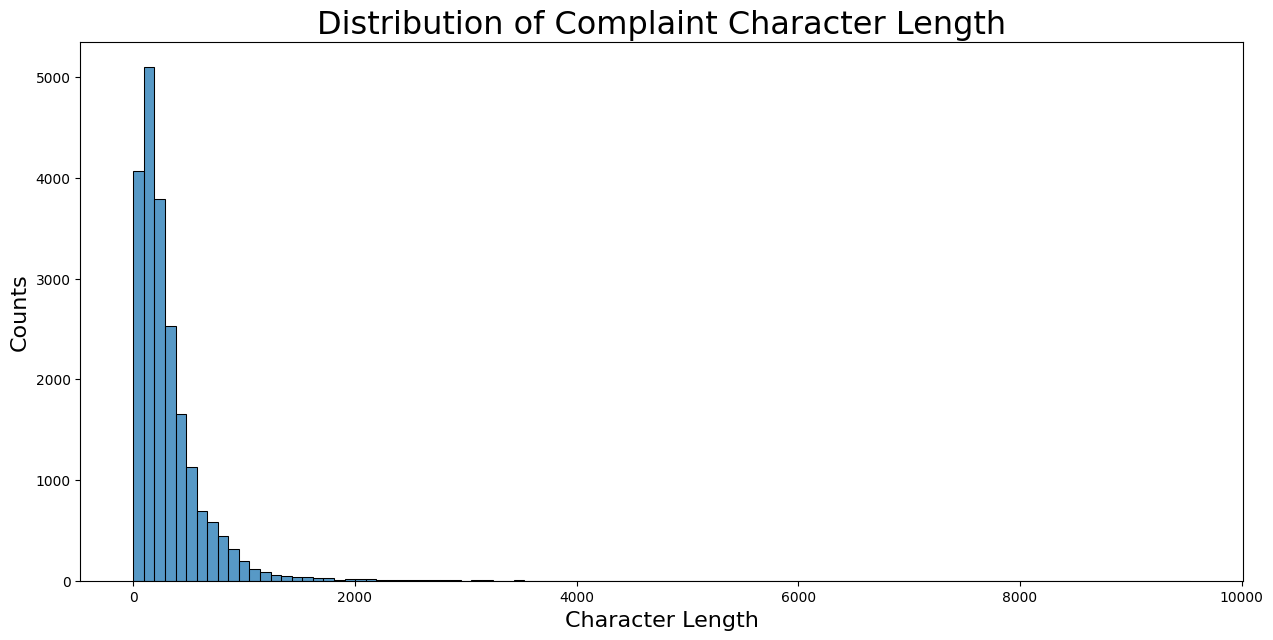

In [27]:
plt.figure(figsize=(15,7))
sns.histplot(char_len, bins=100)
plt.xlabel("Character Length", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.title("Distribution of Complaint Character Length", fontsize=23)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [28]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_font_size=60,
                          min_font_size = 10,
                          max_words=40, 
                          random_state=40
                         ).generate(str(df_clean['complaint_POS_removed']))

# https://www.geeksforgeeks.org/generating-word-cloud-python/

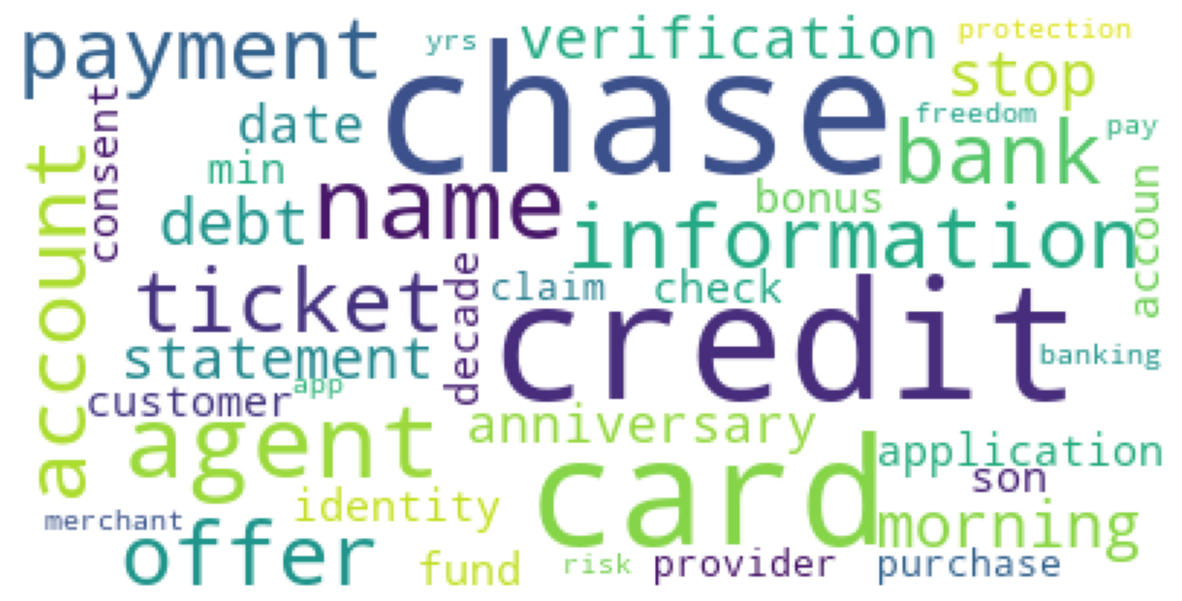

In [29]:
fig = plt.figure(figsize=(15,12))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [30]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
# all the -PRON- are already removed so no need to recheck.

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [31]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def text_ngrams(sentence, n=30, ngrm=(1,1)):
  
  vec = CountVectorizer(stop_words='english', ngram_range=ngrm).fit(sentence)
  bag_o_words = vec.transform(sentence)
  sum_o_words = bag_o_words.sum(axis=0)
  word_fre = [(word, sum_o_words[0, i]) for word, i in vec.vocabulary_.items()]
  word_fre.sort(key=lambda x: x[1], reverse=True)

  return word_fre[:n]

In [32]:
def plot_bar(data, title= "", xlab="", ylab="" ,figsize=(15, 7),  ):

  cols = data.columns
  plt.figure(figsize=(15, 7))
  sns.barplot(x=cols[0], y=cols[1], data=data)
  
  plt.xticks(rotation=75)
  plt.title(title, size=18)
  plt.xlabel(xlab, size=15)
  plt.ylabel(ylab, size=15)
  plt.show()


# https://www.analyticsvidhya.com/blog/2021/08/understanding-bar-plots-in-python-beginners-guide-to-data-visualization/

In [33]:
#Print the top 10 words in the unigram frequency
unigram_fre =  pd.DataFrame(text_ngrams(df_clean.complaint_POS_removed), columns=["Unigram", "Counts"])
unigram_fre.head(10)

,Unigram,Counts
0,chase,59836
1,account,41159
2,credit,32146
3,card,26467
4,bank,19562
5,payment,13952
6,time,11949
7,money,11934
8,loan,9833
9,information,9626


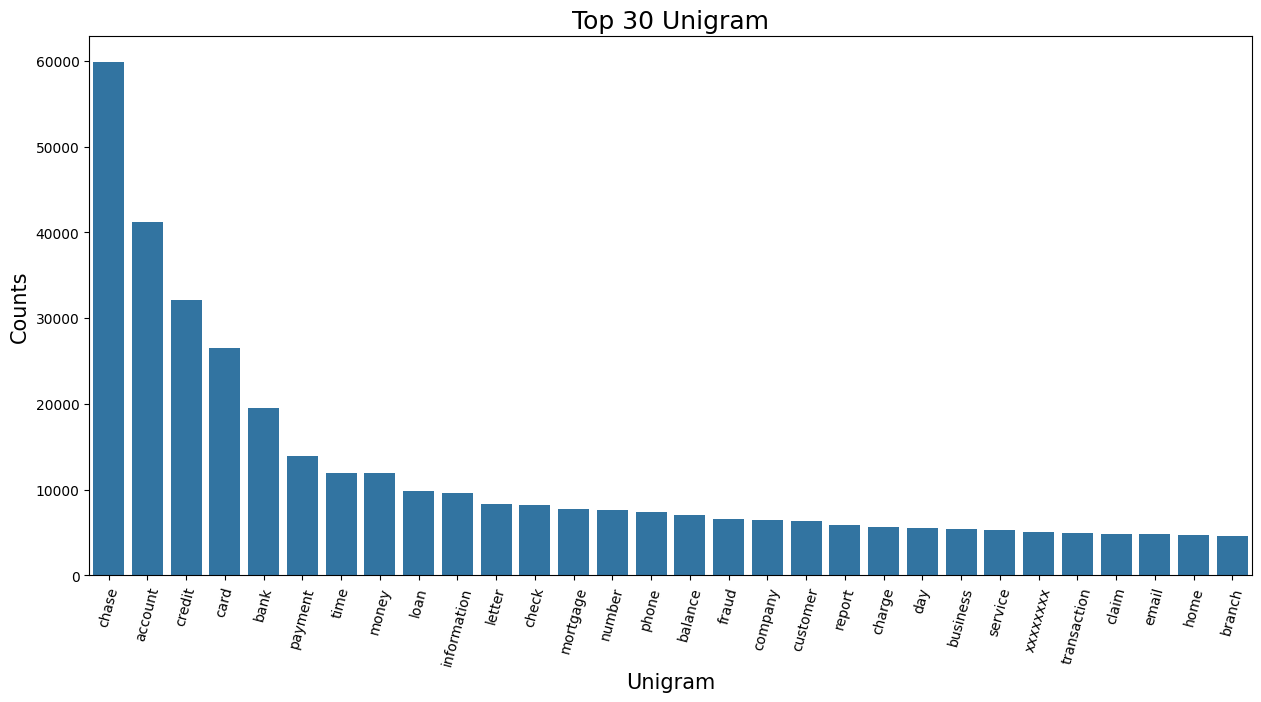

In [34]:
plot_bar(unigram_fre, title="Top 30 Unigram", xlab="Unigram", ylab="Counts")

In [35]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram_fre =  pd.DataFrame(text_ngrams(df_clean.complaint_POS_removed, ngrm=(2,2)), columns=["Bigram", "Counts"],)


In [36]:
#Print the top 10 words in the bigram frequency
bigram_fre.head(10)

,Bigram,Counts
0,credit card,11022
1,account chase,3783
2,chase credit,3706
3,chase bank,3672
4,chase account,3648
5,credit report,3253
6,account account,3119
7,customer service,3000
8,bank account,2465
9,checking account,2455


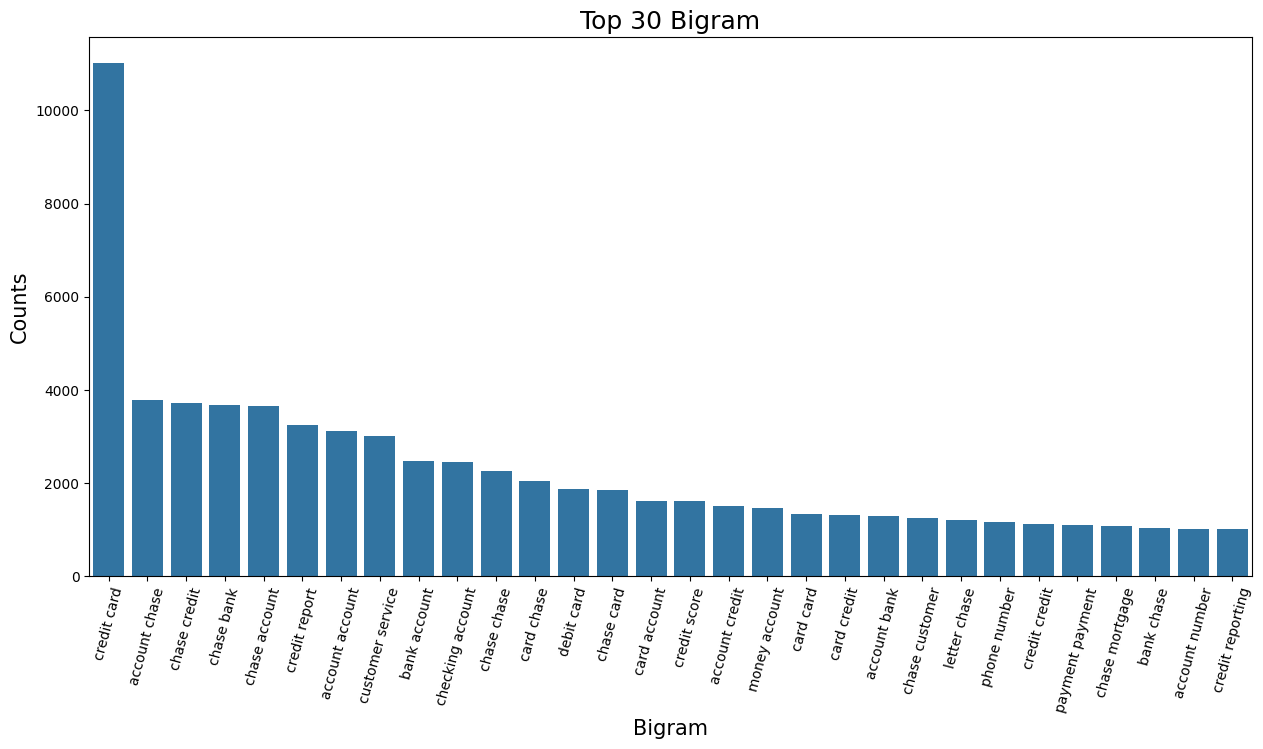

In [37]:
plot_bar(bigram_fre, title="Top 30 Bigram", xlab="Bigram", ylab="Counts")

In [38]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
Trigram_fre =  pd.DataFrame(text_ngrams(df_clean.complaint_POS_removed, ngrm=(3,3)), columns=["Trigram", "Counts"],)


In [39]:
#Print the top 10 words in the trigram frequency
Trigram_fre.head(10)

,Trigram,Counts
0,chase credit card,2033
1,credit card chase,898
2,credit card account,880
3,credit card company,822
4,credit card credit,683
5,chase customer service,640
6,card credit card,497
7,chase bank account,484
8,account chase account,478
9,chase account chase,407


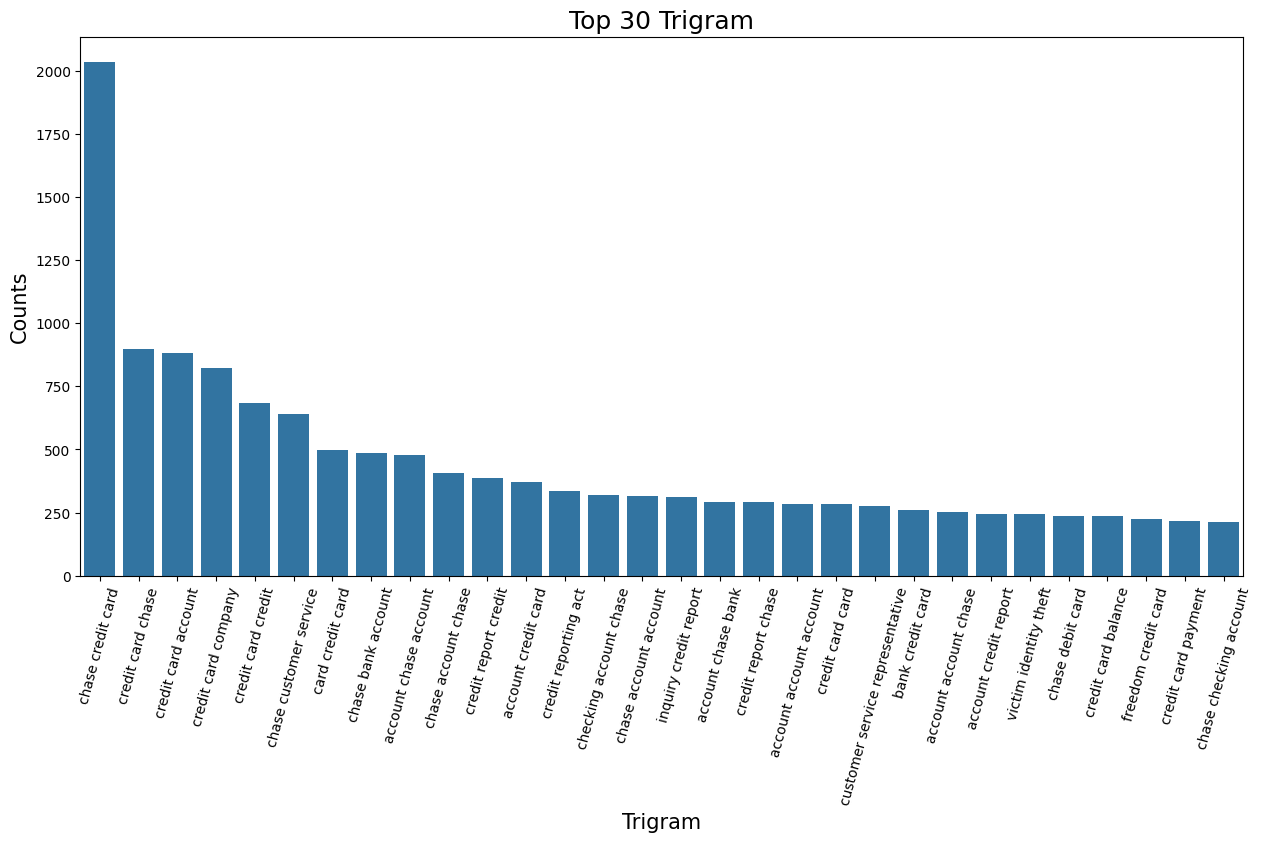

In [40]:
plot_bar(Trigram_fre, title="Top 30 Trigram", xlab="Trigram", ylab="Counts")

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [41]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

All xxxx are already removed from remove POS tag so no need to recheck it.

In [42]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card application identity consent credit...,chase card application identity consent credit...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket card information offer min...,ticket offer ticket card information offer min...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [43]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [44]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_mat = tfidf.fit_transform(df_clean.complaint_POS_removed)


In [45]:
doc_term_mat

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 474024 stored elements and shape (21072, 5810)>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [46]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [47]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [48]:
nmf_model.fit(doc_term_mat)
# len(tfidf.get_feature_names())
len(tfidf.get_feature_names_out())

5810

In [49]:
H = nmf_model.components_

In [50]:
type(H)

numpy.ndarray

In [51]:
H.shape

(5, 5810)

In [52]:
words = np.array(tfidf.get_feature_names_out())
len(words)

5810

In [53]:
words = tfidf.get_feature_names_out()

# Initialize the DataFrame to store top words for each topic
topic_words = pd.DataFrame(index=range(num_topics), columns=[f"Word_{i}" for i in range(15)])

# Loop through each topic to get the top 15 words
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]  # Get top 15 word indices
    topic_words.iloc[i] = [words[j] for j in ix]  # Assign the top words

# Display the result
topic_words



,Word_0,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,Word_10,Word_11,Word_12,Word_13,Word_14
0,account,bank,money,check,chase,checking,branch,deposit,number,business,fraud,transaction,claim,information,day
1,card,chase,credit,charge,dispute,fraud,company,merchant,fee,purchase,time,service,number,phone,customer
2,loan,mortgage,chase,home,modification,property,foreclosure,letter,house,time,rate,sale,information,process,income
3,credit,report,inquiry,score,debt,reporting,information,account,limit,identity,bureaus,company,theft,history,bureau
4,payment,balance,month,statement,fee,date,auto,time,xxxxxxxx,chase,day,error,car,history,transfer


### Observation:
- Topic 0: Bank Branch Realated
- Topic 1: Credit Card
- Topic 2: Loan and Mortgage
- Topic 3: Report, theaf and inquiries
- Topic 4: Presonal Banking


In [54]:
topic_results = nmf_model.transform(doc_term_mat)

In [55]:
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 1, 1, ..., 1, 4, 4])

In [56]:
topic_results.shape

(21072, 5)

In [57]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [58]:
df_clean.shape

(21072, 5)

In [59]:
#Print the first 5 Complaint for each of the Topics
# df_clean=df_clean.groupby('Topic').head(5)
# df_clean.sort_values('Topic')

In [60]:
#Print the first 5 Complaint for each of the Topics
i = 0
for i in range(5):
  temp = df_clean[df_clean['Topic'] == i].head(1)
  if i == 0:
    sample_df = temp
  else:
    sample_df = pd.concat([sample_df, temp], ignore_index = True)
sample_df
# df_clean.sort_values('Topic')

,complaint_what_happened,lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,0
1,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
2,i have been trying to do a loan modification w...,I have be try to do a loan modification with c...,loan modification chase runaround doc,loan modification chase runaround doc,2
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket card information offer min...,ticket offer ticket card information offer min...,3
4,during the summer months i experience a declin...,during the summer month I experience a decline...,summer decline income employment month payment...,summer decline income employment month payment...,4


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [61]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Mortgage/Loan",
               3:"Theft/Dispute Reporting",
               4:"Others"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [62]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [63]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Mortgage/Loan":2,
               "Theft/Dispute Reporting":3,
               "Others":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [64]:
df_clean.tail()

,complaint_what_happened,lemmatized,complaint_POS_removed,Complaint_clean,Topic
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,1
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk chase bank app chase banking merchant...,pay risk chase bank app chase banking merchant...,1
78311,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yrs I ve have ...,credit yrs credit freedom balance life plenty ...,credit yrs credit freedom balance life plenty ...,4
78312,roughly years ago i closed out my accounts wit...,roughly year ago I close out my account with j...,order line credit account payment payment cred...,order line credit account payment payment cred...,4


In [65]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [66]:
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told b...,1
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a xxxx xxxx ticket i c...,3
14,my grand son give me check for i deposit it in...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [67]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [68]:
#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaint_what_happened'])

In [69]:
# Saving Word Vector on disk for later usage
import pickle

pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

In [70]:
# Transform the word vector to tf-idf
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [71]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

In [72]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 33665)
y_train Shape: (15804,)
X_test Shape: (5268, 33665)
y_test Shape: (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Naive Bayes
* Logistic regression
* Decision Tree


**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [73]:
# Create a function to evaluate models
def model_eval(y_test, y_pred, model_name):
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, 
                                target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True,  cmap="GnBu", fmt='d', 
                xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"], 
                yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"])
    plt.show()
    
    return


# https://seaborn.pydata.org/generated/seaborn.heatmap.html

### Model 1 : Naive Bayes

In [74]:
# Import required library
from sklearn.naive_bayes import MultinomialNB

# Run the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Hypuerparameter tuning for best reslt
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [75]:
# Creating model with best hyperparameter
model_name = 'NAIVE BAYES'
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

In [76]:
# Calculate F1 Score of model using weighted average method
f1_nb = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb

np.float64(0.7614220719048991)

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.83      0.80      1528
Credit card or prepaid card       0.78      0.74      0.76      1496
                     Others       0.83      0.84      0.84       933
    Theft/Dispute Reporting       0.68      0.71      0.69       728
              Mortgage/Loan       0.65      0.58      0.61       583

                   accuracy                           0.76      5268
                  macro avg       0.75      0.74      0.74      5268
               weighted avg       0.76      0.76      0.76      5268



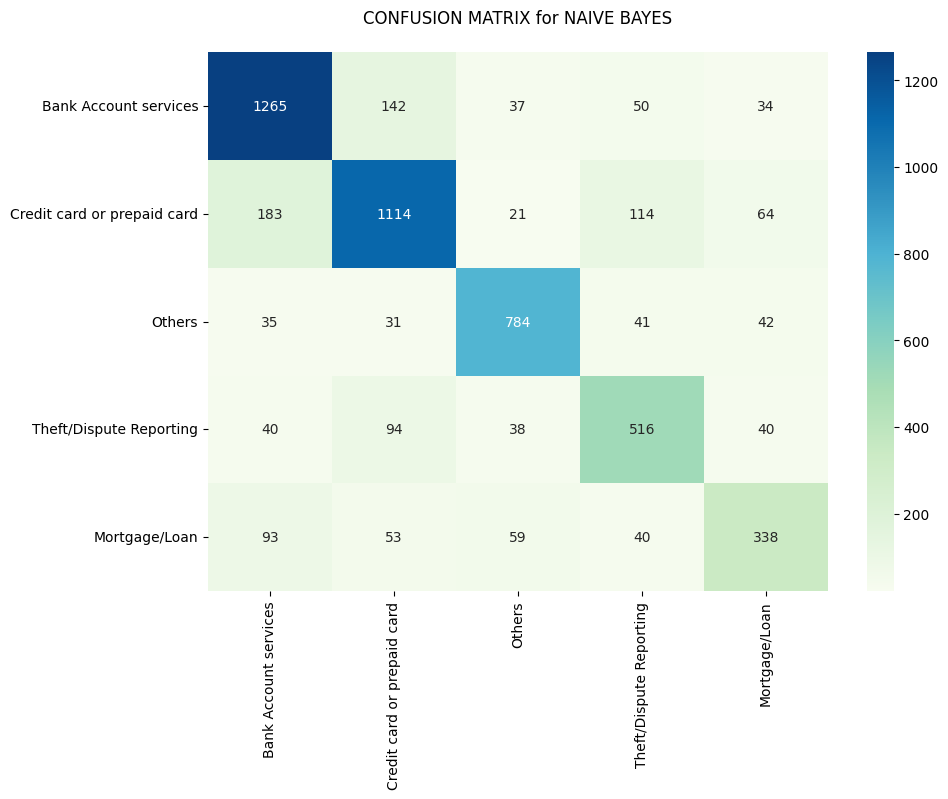

In [77]:
# Evaluate the Naive Bayes classifier
model_eval(y_test, y_pred_nb_tuned, model_name)

In [78]:
# Create a dataframe to store F1 Scores of all models we will build
f1_summary = pd.DataFrame([{'Model': 'Naive Bayes','F1 Score': round(f1_nb, 2)}])
f1_summary

,Model,F1 Score
0,Naive Bayes,0.76


### Model:2 - Logistic Regression

In [79]:
%%time
# Import required library
from sklearn.linear_model import LogisticRegression

# Run the Logistic Regression model with default parameters
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression() 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr,
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\chetna.purohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning:


90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\chetna.purohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\chetna.purohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


{'C': 1, 'penalty': 'l1', 'solver': 'saga'}
CPU times: total: 1min 55s
Wall time: 4min 52s


c:\Users\chetna.purohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [80]:
# Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=1, 
                              penalty='l1', 
                              solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

c:\Users\chetna.purohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



np.float64(0.9483543282880096)

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.95      1528
Credit card or prepaid card       0.95      0.96      0.95      1496
                     Others       0.95      0.94      0.94       933
    Theft/Dispute Reporting       0.94      0.93      0.93       728
              Mortgage/Loan       0.95      0.95      0.95       583

                   accuracy                           0.95      5268
                  macro avg       0.95      0.95      0.95      5268
               weighted avg       0.95      0.95      0.95      5268



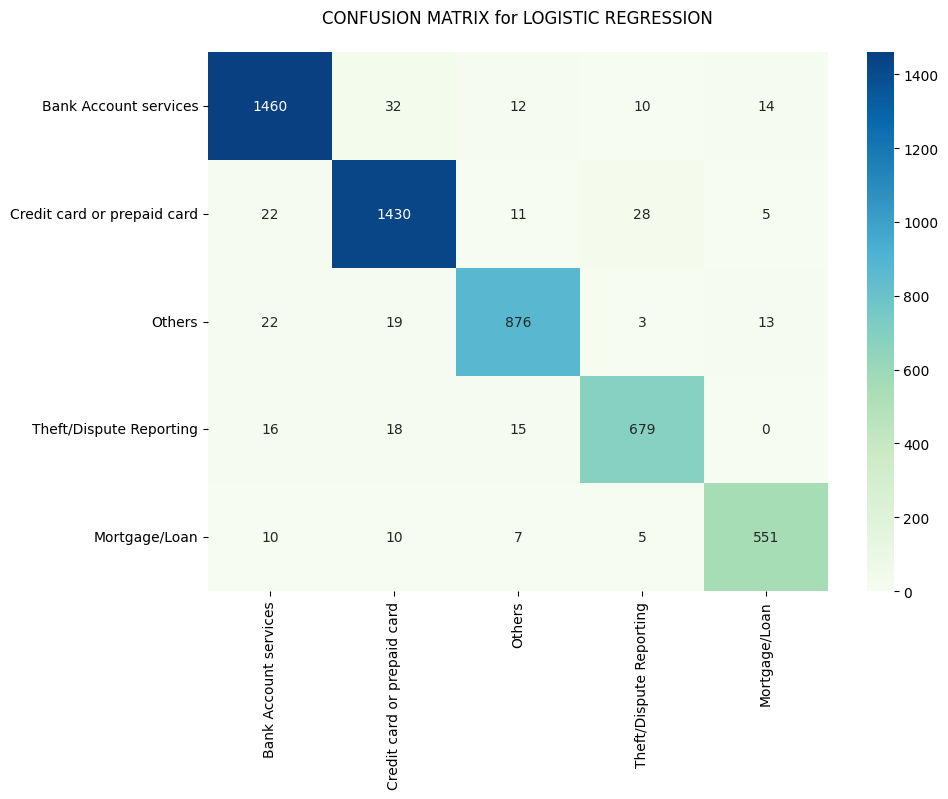

In [81]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_lr_tuned, model_name)

In [82]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Logistic Regression', round(f1_lr, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.76
1,Logistic Regression,0.95


### Model:3 - Decision Tree

In [83]:
%%time
# Import required library
from sklearn.tree import DecisionTreeClassifier

# Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=param_dt,
                       verbose=10,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 15}
CPU times: total: 6.88 s
Wall time: 6min 28s


In [84]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=25, 
                                      min_samples_leaf=15, 
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [85]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

np.float64(0.8354997591953254)

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.84      0.88      0.86      1528
Credit card or prepaid card       0.84      0.84      0.84      1496
                     Others       0.85      0.83      0.84       933
    Theft/Dispute Reporting       0.82      0.79      0.80       728
              Mortgage/Loan       0.83      0.75      0.79       583

                   accuracy                           0.84      5268
                  macro avg       0.83      0.82      0.83      5268
               weighted avg       0.84      0.84      0.84      5268



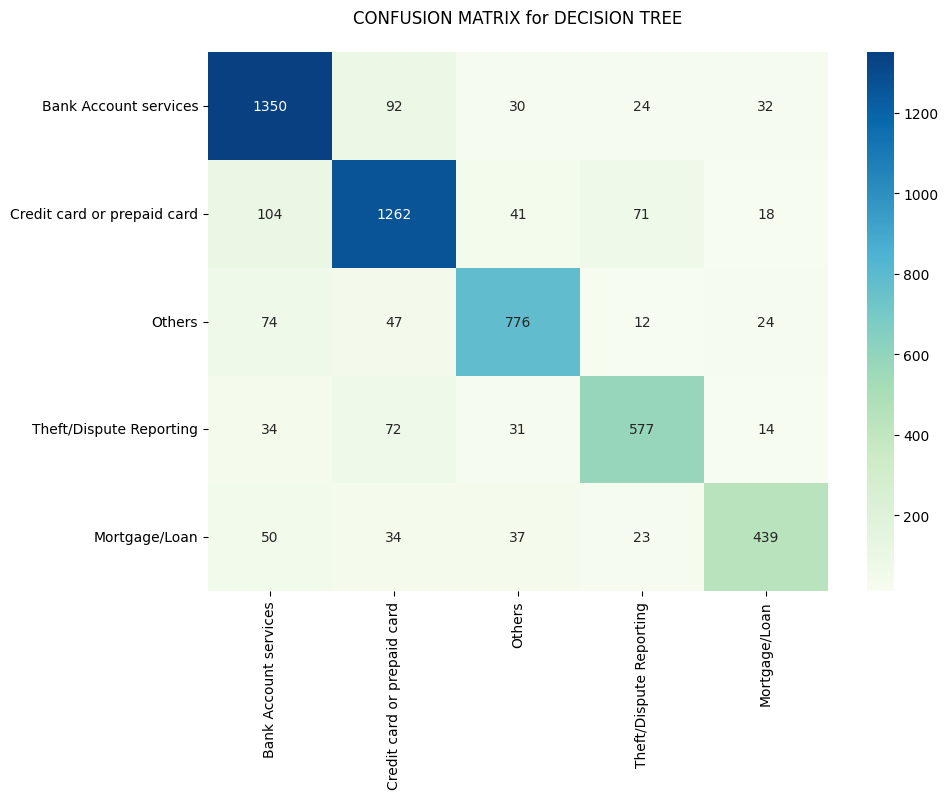

In [86]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt_tuned, model_name)

In [87]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.76
1,Logistic Regression,0.95
2,Decision Tree,0.84


### Model:4 - Random Forest

In [88]:
%%time
# Import required library
from sklearn.ensemble import  RandomForestClassifier


# Run Random Forest with default hyperparameters
model_name = 'Random Forest'
Rf = RandomForestClassifier()
Rf.fit(X_train, y_train)
y_pred_Rf =Rf.predict(X_test)

CPU times: total: 11.2 s
Wall time: 53.9 s


In [89]:
%%time

# Hyperparameter tuning for best result
param_Rf = {
    "min_samples_split": [ 5, 10, 15, 30 ],
    'criterion': ['gini', 'entropy'],
    "n_estimators": [50, 100, 200],
    'max_depth' : [5, 10, 15, 20],
    'min_samples_leaf':[5, 10, 30],
    
}

grid_Rf = GridSearchCV(estimator=Rf, 
                       param_grid=param_Rf,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_Rf.fit(X_train, y_train)
print(grid_Rf.best_params_)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\chetna.purohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning:

invalid value encountered in cast



{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
CPU times: total: 17.5 s
Wall time: 25min 28s


In [90]:
# Creating model with best hyperparameter
Rf_tuned = RandomForestClassifier(criterion = 'gini', 
                                  max_depth = 20, 
                                  min_samples_leaf= 5, 
                                  min_samples_split= 10, 
                                  n_estimators= 50
                                  )
Rf_tuned.fit(X_train, y_train)
y_pred_Rf_tuned = Rf_tuned.predict(X_test)

In [91]:
# Calculate F1 Score of tuned model using weighted average method
f1_Rf = f1_score(y_test, y_pred_Rf_tuned, average="weighted")
f1_Rf

np.float64(0.6989599284449349)

CLASSIFICATION REPORT for Random Forest

                             precision    recall  f1-score   support

      Bank Account services       0.71      0.90      0.80      1528
Credit card or prepaid card       0.65      0.88      0.75      1496
                     Others       0.85      0.82      0.83       933
    Theft/Dispute Reporting       0.88      0.43      0.58       728
              Mortgage/Loan       0.97      0.14      0.25       583

                   accuracy                           0.73      5268
                  macro avg       0.81      0.63      0.64      5268
               weighted avg       0.77      0.73      0.70      5268



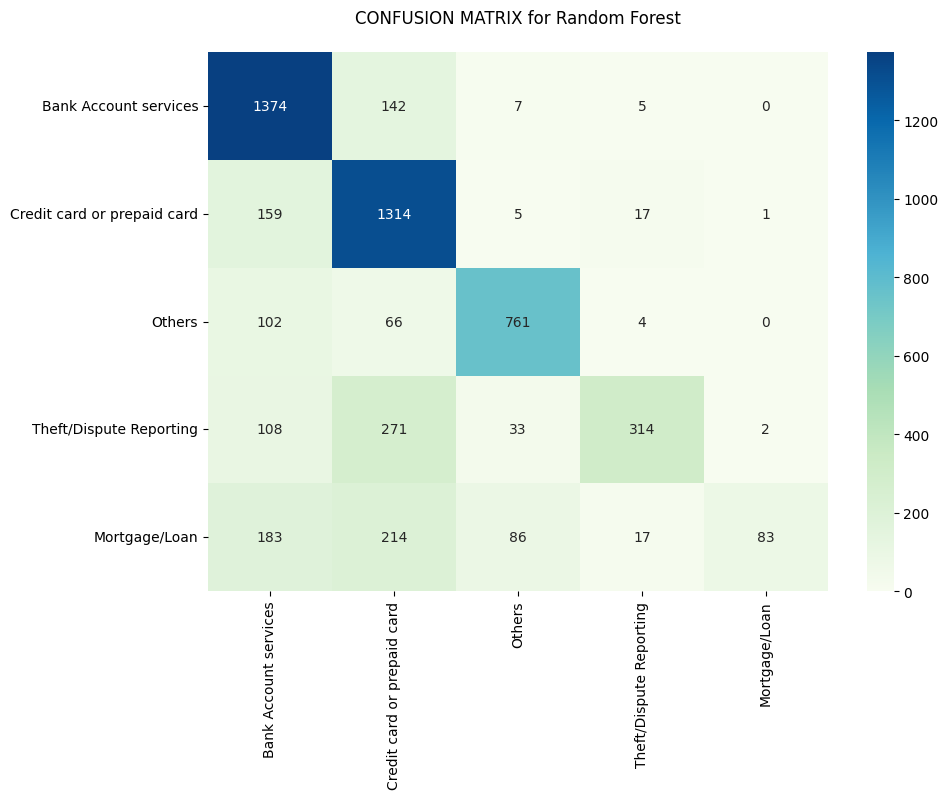

In [92]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_Rf_tuned, model_name)

In [93]:
# f1_summary = f1_summary.loc[f1_summary.Model!="Random Forest"]

In [94]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = [model_name, round(f1_Rf, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.76
1,Logistic Regression,0.95
2,Decision Tree,0.84
3,Random Forest,0.70


### As per the F1 score of all the 4 models, Logistic Regression performs best with F1 score : 0.94




In [95]:
# Save Logistic Regression model as pickle file in device
pickle.dump(lr_tuned, open("logreg_model.pkl", "wb"))
